In [1]:
import os
import sys

ROOT_PATH = os.getcwd()
if "/kaggle" in ROOT_PATH:
    ROOT_PATH = "/kaggle/input"
    sys.path.append(os.path.join(ROOT_PATH, "map-utilities"))

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType

from utils import (
    stringify_input,
    get_model_name,
    get_sequence_classifier,
    get_tokenizer,
    get_training_arguments,
    get_trainer,
)

In [3]:
EPOCHS = 10
MODEL_NAME = get_model_name("/kaggle" in ROOT_PATH, ROOT_PATH)
USE_LORA = False

TRAIN_PATH = os.path.join(ROOT_PATH, "map-charting-student-math-misunderstandings", "train.csv")
TEST_PATH = os.path.join(ROOT_PATH, "map-charting-student-math-misunderstandings", "test.csv")

In [4]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [5]:
print("Training Shape:", train_df.shape)
print("Testing Shape:", test_df.shape)

Training Shape: (36696, 7)
Testing Shape: (3, 5)


In [6]:
train_df.Misconception = train_df.Misconception.fillna("NA")

In [7]:
train_df["predict"] = train_df.Category + ":" + train_df.Misconception

In [8]:
# train_df["is_mc_answer_correct"] = train_df.Category.str.contains("True", case=False)

In [9]:
idx = train_df.Category.str.contains("True", case=False)
tmp = train_df.loc[idx].copy()
tmp["c"] = tmp.groupby(["QuestionId", "MC_Answer"]).MC_Answer.transform("count")
tmp = tmp.sort_values("c", ascending=False)
tmp = tmp.drop_duplicates(["QuestionId"])
tmp = tmp[["QuestionId", "MC_Answer"]]
tmp["is_mc_answer_correct"] = True

train_df = train_df.merge(tmp, on=["QuestionId", "MC_Answer"], how="left")
train_df.is_mc_answer_correct = train_df.is_mc_answer_correct.fillna(False)

test_df = test_df.merge(tmp, on=["QuestionId", "MC_Answer"], how="left")
test_df.is_mc_answer_correct = test_df.is_mc_answer_correct.fillna(False)

/tmp/ipykernel_92791/1307861462.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.is_mc_answer_correct = train_df.is_mc_answer_correct.fillna(False)
/tmp/ipykernel_92791/1307861462.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df.is_mc_answer_correct = test_df.is_mc_answer_correct.fillna(False)


In [10]:
train_df["is_student_explanation_correct"] = train_df.Category.str.contains("Correct", case=False)

In [11]:
le = LabelEncoder()

train_df["label"] = le.fit_transform(train_df["predict"])
n_classes = len(le.classes_)
print(f"Train shape: {train_df.shape} with {n_classes} predict classes")

Train shape: (36696, 11) with 65 predict classes


In [12]:
joblib.dump(le, "label_encoder.joblib")

['label_encoder.joblib']

In [13]:
train_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,predict,is_mc_answer_correct,is_student_explanation_correct,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,True,True,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,True,True,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,True,False,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,True,False,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,True,True,37


In [14]:
model_train_df, model_val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [15]:
model_train_df["stringified_input"] = model_train_df.apply(stringify_input, axis=1)

model_train_df.stringified_input.values[:5]

array(["Question: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there be in Pattern \\( 6 \\) ?\nAnswer: \\( 26 \\)\nThis answer is correct\nStudent's Explanation: apart from the first it add's 4 every time",
       "Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]\nAnswer: \\( \\frac{3}{9} \\)\nThis answer is incorrect\nStudent's Explanation: There are 9 triangles and 3 arent shaded so this means it would be 9/3.",
       "Question: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there be in Pattern \\( 6 \\) ?\nAnswer: \\( 36 \\)\nThis answer is incorrect\nStudent's Exp

In [16]:
# model_val_df.drop(columns=["is_mc_answer_correct", "is_student_explanation_correct"], inplace=True)
model_val_df["stringified_input"] = model_val_df.apply(stringify_input, axis=1)

model_val_df.stringified_input.values[:5]

array(['Question: The probability of an event occurring is \\( 0.9 \\).\n\nWhich of the following most accurately describes the likelihood of the event occurring?\nAnswer: Likely\nThis answer is correct\nStudent\'s Explanation: i think it\'s b because if it\'s certain, you\'re saying that it will happen 100%;however, the number is 0.9 and it isn\'t "certain" so therefore it would be likely',
       "Question: Sally has \\( \\frac{2}{3} \\) of a whole cake in the fridge. Robert eats \\( \\frac{1}{3} \\) of this piece. What fraction of the whole cake has Robert eaten?\nChoose the number sentence that would solve the word problem.\nAnswer: \\( \\frac{2}{3}-\\frac{1}{3} \\)\nThis answer is incorrect\nStudent's Explanation: roberts takes half of the 2/3 so it is -",
       "Question: Calculate \\( \\frac{2}{3} \\times 5 \\)\nAnswer: \\( 3 \\frac{1}{3} \\)\nThis answer is correct\nStudent's Explanation: 2 x 5 is 10 so its 10/3 and 10/3 is also 3 1/3",
       "Question: Which number is the gr

In [17]:
COLUMNS = ["stringified_input", "label"]

train_ds = Dataset.from_pandas(model_train_df[COLUMNS])
val_ds = Dataset.from_pandas(model_val_df[COLUMNS])

In [18]:
seq_model = get_sequence_classifier(MODEL_NAME, n_classes)
tokenizer = get_tokenizer(MODEL_NAME)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/maitri/Downloads/dev/map-kaggle-competition/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [19]:
if USE_LORA:
    peft_config = LoraConfig(
        r=4,
        lora_alpha=16,
        target_modules=["query_proj", "key_proj", "value_proj", "dense"],
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.SEQ_CLS
    )
    seq_model = get_peft_model(seq_model, peft_config)

    for name, p in seq_model.named_parameters():
        if "lora" not in name:
            p.requires_grad = False

In [20]:
def tokenize_function(examples):
    return tokenizer(examples["stringified_input"], truncation=True, padding="max_length", max_length=512)

In [21]:
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)

columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [22]:
training_args = get_training_arguments(
    epochs=EPOCHS,
    train_batch_size=8,
    eval_batch_size=8,
)
trainer = get_trainer(
    seq_model,
    tokenizer,
    training_args,
    train_ds,
    val_ds,
)

/home/maitri/Downloads/dev/map-kaggle-competition/src/utils.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Map@3
200,1.547200,1.556345,0.696458
400,1.346000,1.296778,0.725976
600,1.122300,1.082977,0.769505
800,1.097400,1.027840,0.789078
1000,0.995100,0.879160,0.818847
1200,0.857000,0.799745,0.829791
1400,0.930700,0.865535,0.824319
1600,0.814400,0.826638,0.830154
1800,0.772800,0.895997,0.812035
2000,0.683600,0.838092,0.824546


TrainOutput(global_step=36700, training_loss=0.4160647617114013, metrics={'train_runtime': 38936.5274, 'train_samples_per_second': 7.539, 'train_steps_per_second': 0.943, 'total_flos': 7.728395689660416e+16, 'train_loss': 0.4160647617114013, 'epoch': 10.0})

In [24]:
logs = pd.DataFrame(trainer.state.log_history)
train_loss = logs[logs["loss"].notna()][["step", "loss"]]
eval_loss = logs[logs["eval_loss"].notna()][["step", "eval_loss"]]

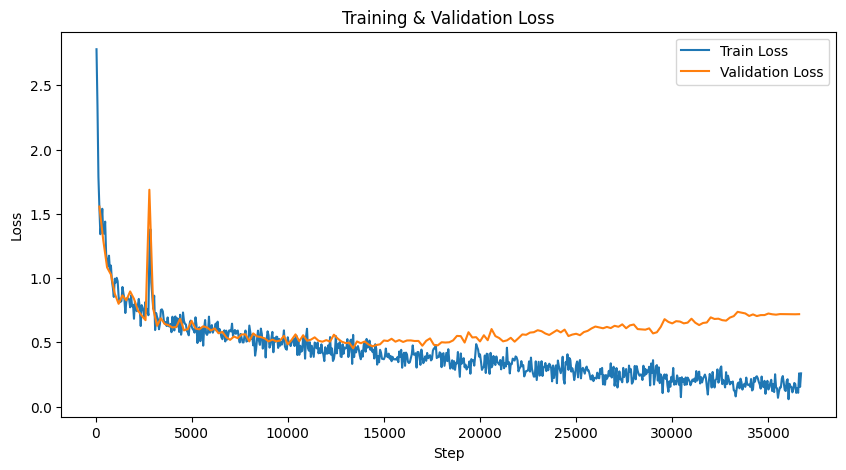

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [26]:
test_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_mc_answer_correct
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",True
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,False
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,True


In [27]:
test_df["stringified_input"] = test_df.apply(stringify_input, axis=1)
test_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_mc_answer_correct,stringified_input
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",True,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,False,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,True,Question: Which number is the greatest?\nAnswe...


In [28]:
test_ds = Dataset.from_pandas(test_df[["stringified_input"]])
test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [29]:
predictions = trainer.predict(test_ds)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

In [30]:
top3 = np.argsort(-probs, axis=1)[:, :3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test_df.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA True_Misconcep...
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA True_Misconcep...
